<a href="https://colab.research.google.com/github/Zilleplus/MachineLearning/blob/feature%2Fadd-HML-chap15-notebooks/HML/chapter15/exampleDeepRNNTimeDistributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt


def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2, = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
n_samples = 10000
series = generate_time_series(batch_size=n_samples, n_steps=n_steps + 10)
x_train, y_train_single = series[:7000, :n_steps], series[:7000, -1]
x_valid, y_valid_single = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test_single = series[9000:, :n_steps], series[9000:, -1]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10+1):
    Y[:, :, step_ahead-1] = series[:, step_ahead:(step_ahead + n_steps), 0]
y_train = Y[:7000]
y_valid = Y[7000:9000]
y_test = Y[9000:]

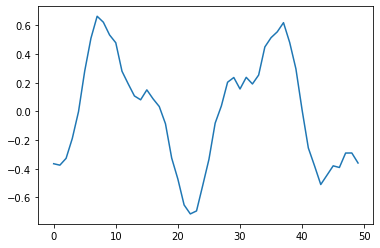

(50, 1)
(50, 10)


In [4]:
# Every sample is a serie of 50 values (x) with 1 prediction (y) at the end.
plt.plot(x_train[0])
plt.show()
print(x_train[0].shape)
print(y_train[0].shape)

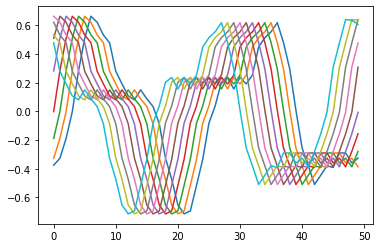

In [5]:
# y_train contains the next 10 values of the series at any perticular point.
assert y_train[0].shape[1] == 10
plt.plot(y_train[0])

In [6]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
])

In [7]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mse",
              optimizer=optimizer, metrics=[last_time_step_mse])
model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_valid, y_valid),
    epochs=20)
[loss, accuracy] = model.test_on_batch(x=x_test, y=y_test)
print("loss=" + str(loss) + " accuracy=" + str(accuracy))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.1618 - last_time_step_mse: 0.1440 - val_loss: 0.1049 - val_last_time_step_mse: 0.0979
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.1014 - last_time_step_mse: 0.0931 - val_loss: 0.0997 - val_last_time_step_mse: 0.0928
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0982 - last_time_step_mse: 0.0900 - val_loss: 0.0976 - val_last_time_step_mse: 0.0904
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0967 - last_time_step_mse: 0.0888 - val_loss: 0.0965 - val_last_time_step_mse: 0.0893
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0958 - last_time_step_mse: 0.0879 - val_loss: 0.0959 - val_last_time_step_mse: 0.0885
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0953 - last_time_step_mse: 0.0874 - val_loss: 0.0954 - val_last_time_step_mse: 0.0882
Epoch 7/20
219/219 [==

In [26]:
f_x = np.expand_dims(x_test[0], axis=0)  # batch of 1 dimension
f_y = y_test[0]
f_pred = model.predict(f_x)
print(np.linalg.norm((f_pred - f_y)*(f_pred - f_y)))

2.640732041926867


(1, 50, 1)
(50,)


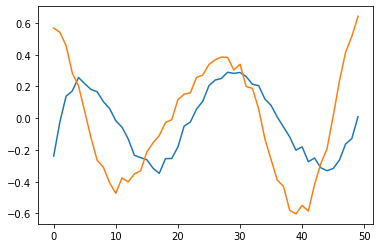

In [45]:
print(f_pred.shape)
print(f_y[:,9].shape)
plt.figure(1)
plt.plot(f_pred[0,:,0])
plt.plot(f_y[:,9])
plt.show()

In [8]:
x_test.shape

(1000, 50, 1)

In [9]:
model.predict(x_test)[0:10].shape

(10, 50, 1)

In [10]:
model.layers[0].weights[0].shape # input_matrix

TensorShape([1, 20])

In [11]:
model.layers[0].weights[1].shape # recurrent matrix

TensorShape([20, 20])

In [12]:
model.layers[1].weights[0].shape

TensorShape([20, 20])

In [13]:
model.layers[1].weights[1].shape

TensorShape([20, 20])

In [21]:
len(model.layers[2].weights)

2

In [51]:
print(model.layers[2].weights[0].shape) # weights on each input
print(model.layers[2].weights[1].shape) # bias

(20, 1)
(1,)
